In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

(7380, 7)
(2460, 2)
0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


In [4]:
max_features = 100000
maxlen = 100
embed_size = 100

print('preprocessing start')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_input) + list(test_input))

X_train1 = tokenizer.texts_to_sequences(train_input)
X_test1 = tokenizer.texts_to_sequences(test_input)
x_train_seq = sequence.pad_sequences(X_train1, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(X_test1, maxlen=maxlen)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

### Read pkl file provided
import gc
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    embeddings_index = pickle.load(g)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print('preprocessing done')

preprocessing start
Found 4620 unique tokens.


/Users/ashleyho/opt/anaconda3/envs/BH2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


preprocessing done


In [18]:
filter_size = 6
max_pool_size = 4
max_pool_strides = 2
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

model = Sequential()
model.add(Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=train_embed))
model.add(Conv1D(filters = 256, kernel_size=6, padding='same', activation='relu',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.5))
model.add(Conv1D(filters = 128, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 64, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Conv1D(filters = 32, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 16, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 8, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         462100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         196736    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)         

In [19]:
import random
randomList = []
random.seed(2020)
# Set a length of the list to 10
for i in range(0, 150):
    # any random numbers from 0 to 1000
    randomList.append(random.randint(0, 7380))

x_val = x_train_seq[randomList]
y_val = train_labels.iloc[randomList]

In [20]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])
            
batch_size = 128
epochs = 50
mod_path = '.Submission5'
mcp_save = ModelCheckpoint(mod_path, save_best_only=True, monitor='val_loss', mode='auto')

early_stopping_monitor = EarlyStopping(monitor='val_loss',  patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-8)


history = model.fit(x_train_seq, train_labels, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_val, y_val),verbose=1, shuffle = True,
                   callbacks=[early_stopping_monitor, mcp_save,reduce_lr])

Train on 7380 samples, validate on 150 samples
Epoch 1/50
7380/7380 [==============================] - 32s 4ms/sample - loss: 0.5174 - accuracy: 0.7213 - val_loss: 0.4506 - val_accuracy: 0.7880
Epoch 2/50
7380/7380 [==============================] - 18s 2ms/sample - loss: 0.3279 - accuracy: 0.8467 - val_loss: 0.5362 - val_accuracy: 0.7400
Epoch 3/50
7380/7380 [==============================] - 19s 3ms/sample - loss: 0.2200 - accuracy: 0.9192 - val_loss: 0.4609 - val_accuracy: 0.8013
Epoch 4/50
7380/7380 [==============================] - 27s 4ms/sample - loss: 0.1533 - accuracy: 0.9493 - val_loss: 0.2502 - val_accuracy: 0.9213
Epoch 5/50
7380/7380 [==============================] - 28s 4ms/sample - loss: 0.1161 - accuracy: 0.9640 - val_loss: 0.2184 - val_accuracy: 0.9307
Epoch 6/50
7380/7380 [==============================] - 27s 4ms/sample - loss: 0.0932 - accuracy: 0.9733 - val_loss: 0.1318 - val_accuracy: 0.9667
Epoch 7/50
7380/7380 [==============================] - 27s 4ms/sample 

In [21]:
model = tf.keras.models.load_model(mod_path)
y_pred_NN = model.predict(x_test_seq, verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


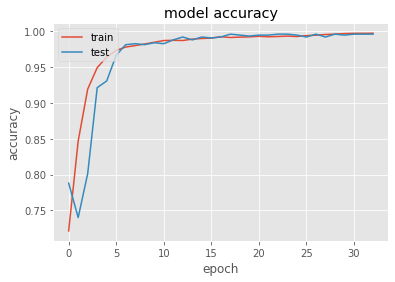

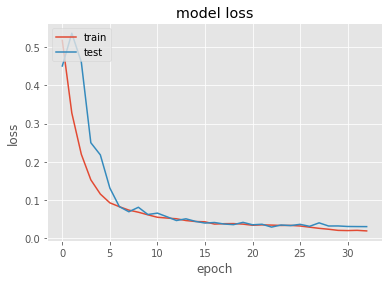

In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = TfidfVectorizer(analyzer='word', ngram_range=(1,6),max_df=1.0,
                        max_features=None, min_df=1)
cvect.fit(train_input)
x_train_vectorized = cvect.transform(train_input)
x_test_vectorized = cvect.transform(test_input)

print(x_train_vectorized.shape)
print(x_test_vectorized.shape)
print(train_labels.shape)

(7380, 330071)
(2460, 330071)
(7380, 5)


In [15]:
### SVC
clf1 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf2 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf3 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf4 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf5 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 

"outwear", "top", "trousers", "women dresses", "women skirts"
clf1.fit(x_train_vectorized, train_labels["outwear"])
clf2.fit(x_train_vectorized, train_labels["top"])
clf3.fit(x_train_vectorized, train_labels["trousers"])
clf4.fit(x_train_vectorized, train_labels["women dresses"])
clf5.fit(x_train_vectorized, train_labels["women skirts"])


y_pred1 = clf1.predict_proba(x_test_vectorized)[:, 1]
y_pred2 = clf2.predict_proba(x_test_vectorized)[:, 1]
y_pred3 = clf3.predict_proba(x_test_vectorized)[:, 1]
y_pred4 = clf4.predict_proba(x_test_vectorized)[:, 1]
y_pred5 = clf5.predict_proba(x_test_vectorized)[:, 1]

y_pred_class_svc = np.stack((y_pred1,y_pred2,y_pred3, y_pred4, y_pred5), axis = 1)

In [16]:
### CatBoost
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(estimator=CatBoostClassifier(loss_function='MultiClass',eval_metric='AUC'
                                                       , verbose=1,learning_rate = 0.1,
                                                      iterations = 1000, rsm = 0.1))
ovr.fit(x_train_vectorized,train_labels)

y_pred_class_cbc = ovr.predict_proba(x_test_vectorized)

0:	total: 1.87s	remaining: 31m 5s
1:	total: 2.69s	remaining: 22m 23s
2:	total: 3.45s	remaining: 19m 7s
3:	total: 4.2s	remaining: 17m 26s
4:	total: 4.95s	remaining: 16m 25s
5:	total: 5.71s	remaining: 15m 45s
6:	total: 6.47s	remaining: 15m 17s
7:	total: 7.22s	remaining: 14m 55s
8:	total: 7.98s	remaining: 14m 39s
9:	total: 8.77s	remaining: 14m 28s
10:	total: 9.53s	remaining: 14m 17s
11:	total: 10.3s	remaining: 14m 8s
12:	total: 11.1s	remaining: 13m 59s
13:	total: 11.8s	remaining: 13m 51s
14:	total: 12.6s	remaining: 13m 45s
15:	total: 13.3s	remaining: 13m 39s
16:	total: 14.1s	remaining: 13m 36s
17:	total: 14.9s	remaining: 13m 31s
18:	total: 15.6s	remaining: 13m 25s
19:	total: 16.3s	remaining: 13m 21s
20:	total: 17.1s	remaining: 13m 16s
21:	total: 17.8s	remaining: 13m 13s
22:	total: 18.6s	remaining: 13m 9s
23:	total: 19.3s	remaining: 13m 6s
24:	total: 20.1s	remaining: 13m 5s
25:	total: 20.9s	remaining: 13m 2s
26:	total: 21.7s	remaining: 13m
27:	total: 22.4s	remaining: 12m 58s
28:	total: 23.

224:	total: 2m 52s	remaining: 9m 53s
225:	total: 2m 53s	remaining: 9m 52s
226:	total: 2m 53s	remaining: 9m 51s
227:	total: 2m 54s	remaining: 9m 50s
228:	total: 2m 55s	remaining: 9m 49s
229:	total: 2m 55s	remaining: 9m 49s
230:	total: 2m 56s	remaining: 9m 48s
231:	total: 2m 57s	remaining: 9m 47s
232:	total: 2m 58s	remaining: 9m 46s
233:	total: 2m 58s	remaining: 9m 45s
234:	total: 2m 59s	remaining: 9m 44s
235:	total: 3m	remaining: 9m 44s
236:	total: 3m 1s	remaining: 9m 43s
237:	total: 3m 1s	remaining: 9m 42s
238:	total: 3m 2s	remaining: 9m 41s
239:	total: 3m 3s	remaining: 9m 40s
240:	total: 3m 4s	remaining: 9m 39s
241:	total: 3m 4s	remaining: 9m 38s
242:	total: 3m 5s	remaining: 9m 38s
243:	total: 3m 6s	remaining: 9m 37s
244:	total: 3m 7s	remaining: 9m 36s
245:	total: 3m 7s	remaining: 9m 35s
246:	total: 3m 8s	remaining: 9m 34s
247:	total: 3m 9s	remaining: 9m 33s
248:	total: 3m 10s	remaining: 9m 33s
249:	total: 3m 10s	remaining: 9m 32s
250:	total: 3m 11s	remaining: 9m 31s
251:	total: 3m 12

449:	total: 5m 40s	remaining: 6m 55s
450:	total: 5m 40s	remaining: 6m 54s
451:	total: 5m 41s	remaining: 6m 54s
452:	total: 5m 42s	remaining: 6m 53s
453:	total: 5m 43s	remaining: 6m 52s
454:	total: 5m 43s	remaining: 6m 52s
455:	total: 5m 44s	remaining: 6m 51s
456:	total: 5m 45s	remaining: 6m 50s
457:	total: 5m 46s	remaining: 6m 49s
458:	total: 5m 46s	remaining: 6m 48s
459:	total: 5m 47s	remaining: 6m 48s
460:	total: 5m 48s	remaining: 6m 47s
461:	total: 5m 49s	remaining: 6m 46s
462:	total: 5m 49s	remaining: 6m 45s
463:	total: 5m 50s	remaining: 6m 45s
464:	total: 5m 51s	remaining: 6m 44s
465:	total: 5m 52s	remaining: 6m 43s
466:	total: 5m 52s	remaining: 6m 42s
467:	total: 5m 53s	remaining: 6m 41s
468:	total: 5m 54s	remaining: 6m 41s
469:	total: 5m 55s	remaining: 6m 40s
470:	total: 5m 55s	remaining: 6m 39s
471:	total: 5m 56s	remaining: 6m 38s
472:	total: 5m 57s	remaining: 6m 37s
473:	total: 5m 57s	remaining: 6m 37s
474:	total: 5m 58s	remaining: 6m 36s
475:	total: 5m 59s	remaining: 6m 35s
4

674:	total: 8m 28s	remaining: 4m 4s
675:	total: 8m 29s	remaining: 4m 3s
676:	total: 8m 29s	remaining: 4m 3s
677:	total: 8m 30s	remaining: 4m 2s
678:	total: 8m 31s	remaining: 4m 1s
679:	total: 8m 31s	remaining: 4m
680:	total: 8m 32s	remaining: 4m
681:	total: 8m 33s	remaining: 3m 59s
682:	total: 8m 34s	remaining: 3m 58s
683:	total: 8m 34s	remaining: 3m 57s
684:	total: 8m 35s	remaining: 3m 57s
685:	total: 8m 36s	remaining: 3m 56s
686:	total: 8m 37s	remaining: 3m 55s
687:	total: 8m 37s	remaining: 3m 54s
688:	total: 8m 38s	remaining: 3m 54s
689:	total: 8m 39s	remaining: 3m 53s
690:	total: 8m 40s	remaining: 3m 52s
691:	total: 8m 40s	remaining: 3m 51s
692:	total: 8m 41s	remaining: 3m 51s
693:	total: 8m 42s	remaining: 3m 50s
694:	total: 8m 43s	remaining: 3m 49s
695:	total: 8m 43s	remaining: 3m 48s
696:	total: 8m 44s	remaining: 3m 48s
697:	total: 8m 45s	remaining: 3m 47s
698:	total: 8m 46s	remaining: 3m 46s
699:	total: 8m 46s	remaining: 3m 45s
700:	total: 8m 47s	remaining: 3m 45s
701:	total: 8m

896:	total: 11m 12s	remaining: 1m 17s
897:	total: 11m 12s	remaining: 1m 16s
898:	total: 11m 13s	remaining: 1m 15s
899:	total: 11m 14s	remaining: 1m 14s
900:	total: 11m 15s	remaining: 1m 14s
901:	total: 11m 15s	remaining: 1m 13s
902:	total: 11m 16s	remaining: 1m 12s
903:	total: 11m 17s	remaining: 1m 11s
904:	total: 11m 18s	remaining: 1m 11s
905:	total: 11m 18s	remaining: 1m 10s
906:	total: 11m 19s	remaining: 1m 9s
907:	total: 11m 20s	remaining: 1m 8s
908:	total: 11m 20s	remaining: 1m 8s
909:	total: 11m 21s	remaining: 1m 7s
910:	total: 11m 22s	remaining: 1m 6s
911:	total: 11m 23s	remaining: 1m 5s
912:	total: 11m 23s	remaining: 1m 5s
913:	total: 11m 24s	remaining: 1m 4s
914:	total: 11m 25s	remaining: 1m 3s
915:	total: 11m 26s	remaining: 1m 2s
916:	total: 11m 26s	remaining: 1m 2s
917:	total: 11m 27s	remaining: 1m 1s
918:	total: 11m 28s	remaining: 1m
919:	total: 11m 29s	remaining: 59.9s
920:	total: 11m 29s	remaining: 59.2s
921:	total: 11m 30s	remaining: 58.4s
922:	total: 11m 31s	remaining: 

121:	total: 1m 43s	remaining: 12m 21s
122:	total: 1m 43s	remaining: 12m 20s
123:	total: 1m 44s	remaining: 12m 18s
124:	total: 1m 45s	remaining: 12m 17s
125:	total: 1m 46s	remaining: 12m 16s
126:	total: 1m 47s	remaining: 12m 15s
127:	total: 1m 47s	remaining: 12m 14s
128:	total: 1m 48s	remaining: 12m 13s
129:	total: 1m 49s	remaining: 12m 12s
130:	total: 1m 50s	remaining: 12m 10s
131:	total: 1m 50s	remaining: 12m 9s
132:	total: 1m 51s	remaining: 12m 8s
133:	total: 1m 52s	remaining: 12m 6s
134:	total: 1m 53s	remaining: 12m 5s
135:	total: 1m 53s	remaining: 12m 3s
136:	total: 1m 54s	remaining: 12m 2s
137:	total: 1m 55s	remaining: 12m
138:	total: 1m 56s	remaining: 11m 59s
139:	total: 1m 56s	remaining: 11m 57s
140:	total: 1m 57s	remaining: 11m 56s
141:	total: 1m 58s	remaining: 11m 55s
142:	total: 1m 59s	remaining: 11m 53s
143:	total: 1m 59s	remaining: 11m 52s
144:	total: 2m	remaining: 11m 50s
145:	total: 2m 1s	remaining: 11m 49s
146:	total: 2m 2s	remaining: 11m 48s
147:	total: 2m 2s	remaining:

342:	total: 4m 26s	remaining: 8m 30s
343:	total: 4m 27s	remaining: 8m 29s
344:	total: 4m 28s	remaining: 8m 28s
345:	total: 4m 28s	remaining: 8m 28s
346:	total: 4m 29s	remaining: 8m 27s
347:	total: 4m 30s	remaining: 8m 26s
348:	total: 4m 31s	remaining: 8m 25s
349:	total: 4m 31s	remaining: 8m 24s
350:	total: 4m 32s	remaining: 8m 23s
351:	total: 4m 33s	remaining: 8m 22s
352:	total: 4m 33s	remaining: 8m 22s
353:	total: 4m 34s	remaining: 8m 21s
354:	total: 4m 35s	remaining: 8m 20s
355:	total: 4m 36s	remaining: 8m 19s
356:	total: 4m 36s	remaining: 8m 18s
357:	total: 4m 37s	remaining: 8m 17s
358:	total: 4m 38s	remaining: 8m 16s
359:	total: 4m 39s	remaining: 8m 16s
360:	total: 4m 39s	remaining: 8m 15s
361:	total: 4m 40s	remaining: 8m 14s
362:	total: 4m 41s	remaining: 8m 13s
363:	total: 4m 42s	remaining: 8m 12s
364:	total: 4m 42s	remaining: 8m 11s
365:	total: 4m 43s	remaining: 8m 11s
366:	total: 4m 44s	remaining: 8m 10s
367:	total: 4m 44s	remaining: 8m 9s
368:	total: 4m 45s	remaining: 8m 8s
369

567:	total: 7m 12s	remaining: 5m 28s
568:	total: 7m 13s	remaining: 5m 28s
569:	total: 7m 13s	remaining: 5m 27s
570:	total: 7m 14s	remaining: 5m 26s
571:	total: 7m 15s	remaining: 5m 25s
572:	total: 7m 16s	remaining: 5m 25s
573:	total: 7m 16s	remaining: 5m 24s
574:	total: 7m 17s	remaining: 5m 23s
575:	total: 7m 18s	remaining: 5m 22s
576:	total: 7m 19s	remaining: 5m 21s
577:	total: 7m 19s	remaining: 5m 21s
578:	total: 7m 20s	remaining: 5m 20s
579:	total: 7m 21s	remaining: 5m 19s
580:	total: 7m 22s	remaining: 5m 18s
581:	total: 7m 22s	remaining: 5m 17s
582:	total: 7m 23s	remaining: 5m 17s
583:	total: 7m 24s	remaining: 5m 16s
584:	total: 7m 24s	remaining: 5m 15s
585:	total: 7m 25s	remaining: 5m 14s
586:	total: 7m 26s	remaining: 5m 14s
587:	total: 7m 27s	remaining: 5m 13s
588:	total: 7m 27s	remaining: 5m 12s
589:	total: 7m 28s	remaining: 5m 11s
590:	total: 7m 29s	remaining: 5m 10s
591:	total: 7m 29s	remaining: 5m 10s
592:	total: 7m 30s	remaining: 5m 9s
593:	total: 7m 31s	remaining: 5m 8s
594

791:	total: 9m 59s	remaining: 2m 37s
792:	total: 9m 59s	remaining: 2m 36s
793:	total: 10m	remaining: 2m 35s
794:	total: 10m 1s	remaining: 2m 35s
795:	total: 10m 2s	remaining: 2m 34s
796:	total: 10m 2s	remaining: 2m 33s
797:	total: 10m 3s	remaining: 2m 32s
798:	total: 10m 4s	remaining: 2m 32s
799:	total: 10m 4s	remaining: 2m 31s
800:	total: 10m 5s	remaining: 2m 30s
801:	total: 10m 6s	remaining: 2m 29s
802:	total: 10m 7s	remaining: 2m 28s
803:	total: 10m 7s	remaining: 2m 28s
804:	total: 10m 8s	remaining: 2m 27s
805:	total: 10m 9s	remaining: 2m 26s
806:	total: 10m 10s	remaining: 2m 25s
807:	total: 10m 10s	remaining: 2m 25s
808:	total: 10m 11s	remaining: 2m 24s
809:	total: 10m 12s	remaining: 2m 23s
810:	total: 10m 12s	remaining: 2m 22s
811:	total: 10m 13s	remaining: 2m 22s
812:	total: 10m 14s	remaining: 2m 21s
813:	total: 10m 15s	remaining: 2m 20s
814:	total: 10m 15s	remaining: 2m 19s
815:	total: 10m 16s	remaining: 2m 19s
816:	total: 10m 17s	remaining: 2m 18s
817:	total: 10m 18s	remaining:

13:	total: 10.8s	remaining: 12m 37s
14:	total: 11.5s	remaining: 12m 34s
15:	total: 12.3s	remaining: 12m 34s
16:	total: 13s	remaining: 12m 32s
17:	total: 13.8s	remaining: 12m 30s
18:	total: 14.5s	remaining: 12m 28s
19:	total: 15.2s	remaining: 12m 26s
20:	total: 16s	remaining: 12m 25s
21:	total: 16.7s	remaining: 12m 23s
22:	total: 17.5s	remaining: 12m 22s
23:	total: 18.2s	remaining: 12m 20s
24:	total: 18.9s	remaining: 12m 18s
25:	total: 19.7s	remaining: 12m 17s
26:	total: 20.4s	remaining: 12m 15s
27:	total: 21.1s	remaining: 12m 14s
28:	total: 21.9s	remaining: 12m 12s
29:	total: 22.6s	remaining: 12m 10s
30:	total: 23.3s	remaining: 12m 9s
31:	total: 24.1s	remaining: 12m 7s
32:	total: 24.8s	remaining: 12m 6s
33:	total: 25.5s	remaining: 12m 5s
34:	total: 26.3s	remaining: 12m 5s
35:	total: 27s	remaining: 12m 3s
36:	total: 27.8s	remaining: 12m 3s
37:	total: 28.5s	remaining: 12m 1s
38:	total: 29.2s	remaining: 12m
39:	total: 30s	remaining: 11m 59s
40:	total: 30.7s	remaining: 11m 57s
41:	total: 3

237:	total: 2m 58s	remaining: 9m 32s
238:	total: 2m 59s	remaining: 9m 31s
239:	total: 3m	remaining: 9m 30s
240:	total: 3m	remaining: 9m 29s
241:	total: 3m 1s	remaining: 9m 28s
242:	total: 3m 2s	remaining: 9m 28s
243:	total: 3m 3s	remaining: 9m 27s
244:	total: 3m 3s	remaining: 9m 26s
245:	total: 3m 4s	remaining: 9m 25s
246:	total: 3m 5s	remaining: 9m 24s
247:	total: 3m 6s	remaining: 9m 24s
248:	total: 3m 6s	remaining: 9m 23s
249:	total: 3m 7s	remaining: 9m 22s
250:	total: 3m 8s	remaining: 9m 21s
251:	total: 3m 8s	remaining: 9m 20s
252:	total: 3m 9s	remaining: 9m 19s
253:	total: 3m 10s	remaining: 9m 19s
254:	total: 3m 11s	remaining: 9m 18s
255:	total: 3m 11s	remaining: 9m 17s
256:	total: 3m 12s	remaining: 9m 16s
257:	total: 3m 13s	remaining: 9m 15s
258:	total: 3m 14s	remaining: 9m 15s
259:	total: 3m 14s	remaining: 9m 14s
260:	total: 3m 15s	remaining: 9m 13s
261:	total: 3m 16s	remaining: 9m 12s
262:	total: 3m 16s	remaining: 9m 11s
263:	total: 3m 17s	remaining: 9m 11s
264:	total: 3m 18s	re

462:	total: 5m 43s	remaining: 6m 38s
463:	total: 5m 44s	remaining: 6m 37s
464:	total: 5m 44s	remaining: 6m 36s
465:	total: 5m 45s	remaining: 6m 35s
466:	total: 5m 46s	remaining: 6m 35s
467:	total: 5m 47s	remaining: 6m 34s
468:	total: 5m 47s	remaining: 6m 33s
469:	total: 5m 48s	remaining: 6m 33s
470:	total: 5m 49s	remaining: 6m 32s
471:	total: 5m 50s	remaining: 6m 31s
472:	total: 5m 50s	remaining: 6m 30s
473:	total: 5m 51s	remaining: 6m 30s
474:	total: 5m 52s	remaining: 6m 29s
475:	total: 5m 52s	remaining: 6m 28s
476:	total: 5m 53s	remaining: 6m 27s
477:	total: 5m 54s	remaining: 6m 26s
478:	total: 5m 55s	remaining: 6m 26s
479:	total: 5m 55s	remaining: 6m 25s
480:	total: 5m 56s	remaining: 6m 24s
481:	total: 5m 57s	remaining: 6m 23s
482:	total: 5m 57s	remaining: 6m 23s
483:	total: 5m 58s	remaining: 6m 22s
484:	total: 5m 59s	remaining: 6m 21s
485:	total: 6m	remaining: 6m 20s
486:	total: 6m	remaining: 6m 20s
487:	total: 6m 1s	remaining: 6m 19s
488:	total: 6m 2s	remaining: 6m 18s
489:	total:

687:	total: 8m 28s	remaining: 3m 50s
688:	total: 8m 28s	remaining: 3m 49s
689:	total: 8m 29s	remaining: 3m 49s
690:	total: 8m 30s	remaining: 3m 48s
691:	total: 8m 31s	remaining: 3m 47s
692:	total: 8m 32s	remaining: 3m 46s
693:	total: 8m 32s	remaining: 3m 46s
694:	total: 8m 33s	remaining: 3m 45s
695:	total: 8m 34s	remaining: 3m 44s
696:	total: 8m 35s	remaining: 3m 43s
697:	total: 8m 35s	remaining: 3m 43s
698:	total: 8m 36s	remaining: 3m 42s
699:	total: 8m 37s	remaining: 3m 41s
700:	total: 8m 38s	remaining: 3m 40s
701:	total: 8m 38s	remaining: 3m 40s
702:	total: 8m 39s	remaining: 3m 39s
703:	total: 8m 40s	remaining: 3m 38s
704:	total: 8m 41s	remaining: 3m 38s
705:	total: 8m 41s	remaining: 3m 37s
706:	total: 8m 42s	remaining: 3m 36s
707:	total: 8m 43s	remaining: 3m 35s
708:	total: 8m 43s	remaining: 3m 35s
709:	total: 8m 44s	remaining: 3m 34s
710:	total: 8m 45s	remaining: 3m 33s
711:	total: 8m 46s	remaining: 3m 32s
712:	total: 8m 46s	remaining: 3m 32s
713:	total: 8m 47s	remaining: 3m 31s
7

909:	total: 11m 12s	remaining: 1m 6s
910:	total: 11m 13s	remaining: 1m 5s
911:	total: 11m 14s	remaining: 1m 5s
912:	total: 11m 14s	remaining: 1m 4s
913:	total: 11m 15s	remaining: 1m 3s
914:	total: 11m 16s	remaining: 1m 2s
915:	total: 11m 17s	remaining: 1m 2s
916:	total: 11m 17s	remaining: 1m 1s
917:	total: 11m 18s	remaining: 1m
918:	total: 11m 19s	remaining: 59.9s
919:	total: 11m 20s	remaining: 59.1s
920:	total: 11m 20s	remaining: 58.4s
921:	total: 11m 21s	remaining: 57.7s
922:	total: 11m 22s	remaining: 56.9s
923:	total: 11m 22s	remaining: 56.2s
924:	total: 11m 23s	remaining: 55.4s
925:	total: 11m 24s	remaining: 54.7s
926:	total: 11m 25s	remaining: 54s
927:	total: 11m 25s	remaining: 53.2s
928:	total: 11m 26s	remaining: 52.5s
929:	total: 11m 27s	remaining: 51.7s
930:	total: 11m 28s	remaining: 51s
931:	total: 11m 28s	remaining: 50.3s
932:	total: 11m 29s	remaining: 49.5s
933:	total: 11m 30s	remaining: 48.8s
934:	total: 11m 30s	remaining: 48s
935:	total: 11m 31s	remaining: 47.3s
936:	total

135:	total: 1m 47s	remaining: 11m 21s
136:	total: 1m 48s	remaining: 11m 20s
137:	total: 1m 48s	remaining: 11m 19s
138:	total: 1m 49s	remaining: 11m 18s
139:	total: 1m 50s	remaining: 11m 17s
140:	total: 1m 51s	remaining: 11m 16s
141:	total: 1m 51s	remaining: 11m 16s
142:	total: 1m 52s	remaining: 11m 15s
143:	total: 1m 53s	remaining: 11m 14s
144:	total: 1m 54s	remaining: 11m 13s
145:	total: 1m 54s	remaining: 11m 12s
146:	total: 1m 55s	remaining: 11m 11s
147:	total: 1m 56s	remaining: 11m 10s
148:	total: 1m 57s	remaining: 11m 9s
149:	total: 1m 58s	remaining: 11m 8s
150:	total: 1m 58s	remaining: 11m 7s
151:	total: 1m 59s	remaining: 11m 6s
152:	total: 2m	remaining: 11m 6s
153:	total: 2m 1s	remaining: 11m 5s
154:	total: 2m 1s	remaining: 11m 4s
155:	total: 2m 2s	remaining: 11m 3s
156:	total: 2m 3s	remaining: 11m 2s
157:	total: 2m 4s	remaining: 11m 2s
158:	total: 2m 5s	remaining: 11m 1s
159:	total: 2m 5s	remaining: 11m
160:	total: 2m 6s	remaining: 11m
161:	total: 2m 7s	remaining: 10m 59s
162:	t

357:	total: 4m 39s	remaining: 8m 20s
358:	total: 4m 40s	remaining: 8m 20s
359:	total: 4m 40s	remaining: 8m 19s
360:	total: 4m 41s	remaining: 8m 18s
361:	total: 4m 42s	remaining: 8m 17s
362:	total: 4m 43s	remaining: 8m 17s
363:	total: 4m 44s	remaining: 8m 16s
364:	total: 4m 44s	remaining: 8m 15s
365:	total: 4m 45s	remaining: 8m 14s
366:	total: 4m 46s	remaining: 8m 14s
367:	total: 4m 47s	remaining: 8m 13s
368:	total: 4m 48s	remaining: 8m 12s
369:	total: 4m 48s	remaining: 8m 11s
370:	total: 4m 49s	remaining: 8m 11s
371:	total: 4m 50s	remaining: 8m 10s
372:	total: 4m 51s	remaining: 8m 9s
373:	total: 4m 51s	remaining: 8m 8s
374:	total: 4m 52s	remaining: 8m 7s
375:	total: 4m 53s	remaining: 8m 6s
376:	total: 4m 54s	remaining: 8m 6s
377:	total: 4m 54s	remaining: 8m 5s
378:	total: 4m 55s	remaining: 8m 4s
379:	total: 4m 56s	remaining: 8m 3s
380:	total: 4m 57s	remaining: 8m 2s
381:	total: 4m 57s	remaining: 8m 1s
382:	total: 4m 58s	remaining: 8m 1s
383:	total: 4m 59s	remaining: 8m
384:	total: 5m	r

582:	total: 7m 35s	remaining: 5m 25s
583:	total: 7m 36s	remaining: 5m 24s
584:	total: 7m 36s	remaining: 5m 24s
585:	total: 7m 37s	remaining: 5m 23s
586:	total: 7m 38s	remaining: 5m 22s
587:	total: 7m 39s	remaining: 5m 21s
588:	total: 7m 39s	remaining: 5m 20s
589:	total: 7m 40s	remaining: 5m 20s
590:	total: 7m 41s	remaining: 5m 19s
591:	total: 7m 42s	remaining: 5m 18s
592:	total: 7m 43s	remaining: 5m 17s
593:	total: 7m 43s	remaining: 5m 17s
594:	total: 7m 44s	remaining: 5m 16s
595:	total: 7m 45s	remaining: 5m 15s
596:	total: 7m 46s	remaining: 5m 14s
597:	total: 7m 47s	remaining: 5m 14s
598:	total: 7m 47s	remaining: 5m 13s
599:	total: 7m 48s	remaining: 5m 12s
600:	total: 7m 49s	remaining: 5m 11s
601:	total: 7m 50s	remaining: 5m 10s
602:	total: 7m 50s	remaining: 5m 9s
603:	total: 7m 51s	remaining: 5m 9s
604:	total: 7m 52s	remaining: 5m 8s
605:	total: 7m 53s	remaining: 5m 7s
606:	total: 7m 53s	remaining: 5m 6s
607:	total: 7m 54s	remaining: 5m 5s
608:	total: 7m 55s	remaining: 5m 5s
609:	tot

805:	total: 10m 30s	remaining: 2m 31s
806:	total: 10m 31s	remaining: 2m 30s
807:	total: 10m 32s	remaining: 2m 30s
808:	total: 10m 32s	remaining: 2m 29s
809:	total: 10m 33s	remaining: 2m 28s
810:	total: 10m 34s	remaining: 2m 27s
811:	total: 10m 35s	remaining: 2m 27s
812:	total: 10m 35s	remaining: 2m 26s
813:	total: 10m 36s	remaining: 2m 25s
814:	total: 10m 37s	remaining: 2m 24s
815:	total: 10m 38s	remaining: 2m 23s
816:	total: 10m 39s	remaining: 2m 23s
817:	total: 10m 39s	remaining: 2m 22s
818:	total: 10m 40s	remaining: 2m 21s
819:	total: 10m 41s	remaining: 2m 20s
820:	total: 10m 42s	remaining: 2m 20s
821:	total: 10m 42s	remaining: 2m 19s
822:	total: 10m 43s	remaining: 2m 18s
823:	total: 10m 44s	remaining: 2m 17s
824:	total: 10m 45s	remaining: 2m 16s
825:	total: 10m 45s	remaining: 2m 16s
826:	total: 10m 46s	remaining: 2m 15s
827:	total: 10m 47s	remaining: 2m 14s
828:	total: 10m 48s	remaining: 2m 13s
829:	total: 10m 48s	remaining: 2m 12s
830:	total: 10m 49s	remaining: 2m 12s
831:	total: 

27:	total: 23.8s	remaining: 13m 44s
28:	total: 24.7s	remaining: 13m 45s
29:	total: 25.5s	remaining: 13m 44s
30:	total: 26.3s	remaining: 13m 42s
31:	total: 27.1s	remaining: 13m 40s
32:	total: 28s	remaining: 13m 39s
33:	total: 28.8s	remaining: 13m 37s
34:	total: 29.6s	remaining: 13m 35s
35:	total: 30.4s	remaining: 13m 34s
36:	total: 31.3s	remaining: 13m 34s
37:	total: 32.1s	remaining: 13m 32s
38:	total: 32.9s	remaining: 13m 31s
39:	total: 33.7s	remaining: 13m 29s
40:	total: 34.5s	remaining: 13m 27s
41:	total: 35.3s	remaining: 13m 25s
42:	total: 36.1s	remaining: 13m 23s
43:	total: 36.9s	remaining: 13m 21s
44:	total: 37.7s	remaining: 13m 19s
45:	total: 38.5s	remaining: 13m 17s
46:	total: 39.3s	remaining: 13m 17s
47:	total: 40.1s	remaining: 13m 15s
48:	total: 40.9s	remaining: 13m 14s
49:	total: 41.8s	remaining: 13m 13s
50:	total: 42.6s	remaining: 13m 12s
51:	total: 43.4s	remaining: 13m 11s
52:	total: 44.2s	remaining: 13m 10s
53:	total: 45s	remaining: 13m 8s
54:	total: 45.8s	remaining: 13m 7

249:	total: 3m 24s	remaining: 10m 13s
250:	total: 3m 25s	remaining: 10m 12s
251:	total: 3m 26s	remaining: 10m 11s
252:	total: 3m 26s	remaining: 10m 11s
253:	total: 3m 27s	remaining: 10m 10s
254:	total: 3m 28s	remaining: 10m 9s
255:	total: 3m 29s	remaining: 10m 8s
256:	total: 3m 30s	remaining: 10m 8s
257:	total: 3m 31s	remaining: 10m 7s
258:	total: 3m 32s	remaining: 10m 6s
259:	total: 3m 32s	remaining: 10m 5s
260:	total: 3m 33s	remaining: 10m 4s
261:	total: 3m 34s	remaining: 10m 4s
262:	total: 3m 35s	remaining: 10m 3s
263:	total: 3m 36s	remaining: 10m 2s
264:	total: 3m 36s	remaining: 10m 1s
265:	total: 3m 37s	remaining: 10m
266:	total: 3m 38s	remaining: 10m
267:	total: 3m 39s	remaining: 9m 59s
268:	total: 3m 40s	remaining: 9m 58s
269:	total: 3m 41s	remaining: 9m 57s
270:	total: 3m 41s	remaining: 9m 56s
271:	total: 3m 42s	remaining: 9m 55s
272:	total: 3m 43s	remaining: 9m 55s
273:	total: 3m 44s	remaining: 9m 54s
274:	total: 3m 45s	remaining: 9m 53s
275:	total: 3m 45s	remaining: 9m 52s
27

473:	total: 6m 28s	remaining: 7m 11s
474:	total: 6m 29s	remaining: 7m 10s
475:	total: 6m 30s	remaining: 7m 9s
476:	total: 6m 31s	remaining: 7m 9s
477:	total: 6m 32s	remaining: 7m 8s
478:	total: 6m 33s	remaining: 7m 7s
479:	total: 6m 33s	remaining: 7m 6s
480:	total: 6m 34s	remaining: 7m 5s
481:	total: 6m 35s	remaining: 7m 5s
482:	total: 6m 36s	remaining: 7m 4s
483:	total: 6m 37s	remaining: 7m 3s
484:	total: 6m 37s	remaining: 7m 2s
485:	total: 6m 38s	remaining: 7m 1s
486:	total: 6m 39s	remaining: 7m
487:	total: 6m 40s	remaining: 7m
488:	total: 6m 41s	remaining: 6m 59s
489:	total: 6m 41s	remaining: 6m 58s
490:	total: 6m 42s	remaining: 6m 57s
491:	total: 6m 43s	remaining: 6m 56s
492:	total: 6m 44s	remaining: 6m 55s
493:	total: 6m 45s	remaining: 6m 55s
494:	total: 6m 46s	remaining: 6m 54s
495:	total: 6m 46s	remaining: 6m 53s
496:	total: 6m 47s	remaining: 6m 52s
497:	total: 6m 48s	remaining: 6m 51s
498:	total: 6m 49s	remaining: 6m 50s
499:	total: 6m 50s	remaining: 6m 50s
500:	total: 6m 50s	r

698:	total: 9m 32s	remaining: 4m 6s
699:	total: 9m 33s	remaining: 4m 5s
700:	total: 9m 34s	remaining: 4m 4s
701:	total: 9m 34s	remaining: 4m 4s
702:	total: 9m 35s	remaining: 4m 3s
703:	total: 9m 36s	remaining: 4m 2s
704:	total: 9m 37s	remaining: 4m 1s
705:	total: 9m 38s	remaining: 4m
706:	total: 9m 38s	remaining: 3m 59s
707:	total: 9m 39s	remaining: 3m 59s
708:	total: 9m 40s	remaining: 3m 58s
709:	total: 9m 41s	remaining: 3m 57s
710:	total: 9m 42s	remaining: 3m 56s
711:	total: 9m 42s	remaining: 3m 55s
712:	total: 9m 43s	remaining: 3m 54s
713:	total: 9m 44s	remaining: 3m 54s
714:	total: 9m 45s	remaining: 3m 53s
715:	total: 9m 45s	remaining: 3m 52s
716:	total: 9m 46s	remaining: 3m 51s
717:	total: 9m 47s	remaining: 3m 50s
718:	total: 9m 48s	remaining: 3m 49s
719:	total: 9m 49s	remaining: 3m 49s
720:	total: 9m 49s	remaining: 3m 48s
721:	total: 9m 50s	remaining: 3m 47s
722:	total: 9m 51s	remaining: 3m 46s
723:	total: 9m 52s	remaining: 3m 45s
724:	total: 9m 52s	remaining: 3m 44s
725:	total: 

918:	total: 12m 35s	remaining: 1m 6s
919:	total: 12m 35s	remaining: 1m 5s
920:	total: 12m 36s	remaining: 1m 4s
921:	total: 12m 37s	remaining: 1m 4s
922:	total: 12m 38s	remaining: 1m 3s
923:	total: 12m 39s	remaining: 1m 2s
924:	total: 12m 40s	remaining: 1m 1s
925:	total: 12m 40s	remaining: 1m
926:	total: 12m 41s	remaining: 60s
927:	total: 12m 42s	remaining: 59.2s
928:	total: 12m 43s	remaining: 58.4s
929:	total: 12m 44s	remaining: 57.5s
930:	total: 12m 45s	remaining: 56.7s
931:	total: 12m 46s	remaining: 55.9s
932:	total: 12m 46s	remaining: 55.1s
933:	total: 12m 47s	remaining: 54.3s
934:	total: 12m 48s	remaining: 53.4s
935:	total: 12m 49s	remaining: 52.6s
936:	total: 12m 50s	remaining: 51.8s
937:	total: 12m 51s	remaining: 51s
938:	total: 12m 52s	remaining: 50.2s
939:	total: 12m 52s	remaining: 49.3s
940:	total: 12m 53s	remaining: 48.5s
941:	total: 12m 54s	remaining: 47.7s
942:	total: 12m 55s	remaining: 46.9s
943:	total: 12m 56s	remaining: 46.1s
944:	total: 12m 57s	remaining: 45.2s
945:	tot

In [23]:
y_pred_all = (y_pred_NN + y_pred_class_svc + y_pred_class_cbc) / 3
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_all]

In [24]:
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission5.csv',index = False)

In [25]:
labels = pd.DataFrame(y_pred_all, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission5(prob).csv',index = False)